<a href="https://colab.research.google.com/github/DanChernis/DataScienceLab/blob/main/Copy_of_Almog_Valid_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style='text-align: right;' dir='rtl'>
סדנה במדעי הנתונים
</h1>
<h5 style='text-align: right;' dir='rtl'>
המשימה שבחרנו לקחת על עצמנו בפרויקט הזה הוא תרגום שפת סימנים אמריקאית לטקסט.
ישנם חירשים רבים בעולם, שפת הסימנים המוכרת ביותר בעולם היא שפת סימנים אמריקאית.
למרות הכמות הגדולה של חירשים (ואילמים) שמתקשרים באמצעות שפת הסימנים שפת הסימנים אינה שפה מוכרת
נראה שדוברי שפת הסימנים מסוגלים לסמן בשפת הסימנים מהר יותר משהם מסוגלים לכתוב
רשת ניורנים שתדע לתרגם בין שפת הסימנים לאנגלית תעזור לחירשים להשתמש במקבילה שלהם לתוכנות text2speech
ולקדם הבנה בין דוברי שפת הסימנים לאלו שאינם דוברי שפת הסימנים
</h5>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ייבוא הספריות
<h5 style='text-align: right;'>
בקוד הבסיסי במחברת זאת המטרה היא ויזואלזציה וניתוח המידע במודל טרנספורמר פשוט
נייבא את
matplotlib לויזואלזציה
mediapipe להצגת מידע מסרטון
pandas לניתוח נוסף של המידע
וכמובן את tensorflow המכיל את keras לרשת
</h5>

In [15]:
!pip3 install mediapipe
import os
import shutil
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
import json
import mediapipe
import matplotlib
import matplotlib.pyplot as plt
import random

from skimage.transform import resize
from mediapipe.framework.formats import landmark_pb2
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
from matplotlib import animation, rc
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [16]:
print("TensorFlow v" + tf.__version__)
print("Mediapipe v" + mediapipe.__version__)

TensorFlow v2.14.0
Mediapipe v0.10.9


<h1 style='text-align: right;' dir='rtl'>
טעינת המידע
</h1>
<h5 style='text-align: right;' dir='rtl'>
המידע הוא מידע מעובד מסרטונים.
ישנם סרטונים בהם אנשים סימנו מילים בשפת הסימנים. אלגוריתם זיהוי ידיים זיהה כל פרק ביד
ושם נקודה בעלת קורדינאטות תלת מימדיות על כל פרק ביד
הסרטונים המעובדים שמורים בקובץ parquet
הקשר בין הסרטונים לביטווים שמור בקובץ csv
נראה שיש בידנו 67208 סרטונים
</h5>

In [17]:
dataset_df = pd.read_csv('/content/drive/MyDrive/asl-fingerspelling/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (67208, 5)


ישנם 67208 סרטונים בעלי 5 תכונות נתיב הקובץ, מספר קובץ, מספר רצף,מספר זיהוי משתמש וביטוי

In [18]:
dataset_df.head()

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


<h1 style='text-align: right;' dir='rtl'>
חקירה פשוטה של המידע
</h1>
<h5 style='text-align: right;' dir='rtl'>
במחלקה הבאה נראה את תוכן המידע
בתמונה המצורפת יש גרף המתאר את איך שהמידע מקושר ומסודר
</h5>

![files2.png](attachment:751e38db-4def-4177-bf5b-27071bb1b3e3.png)

<h5 style='text-align: right;' dir='rtl'>
נקרא את השורה הראשונה מסט האימונים
</h5>

In [19]:
# Fetch sequence_id, file_id, phrase from first row
sequence_id, file_id, phrase = dataset_df.iloc[0][['sequence_id', 'file_id', 'phrase']]
print(f"sequence_id: {sequence_id}, file_id: {file_id}, phrase: {phrase}")

sequence_id: 1816796431, file_id: 5414471, phrase: 3 creekhouse


<h5 style='text-align: right;' dir='rtl'>
נפתח את הקובץ ונראה את מספר הרצף
</h5>

In [20]:
# Fetch data from parquet file
sample_sequence_df = pq.read_table(
    f"/content/drive/MyDrive/asl-fingerspelling/train_landmarks/{str(file_id)}.parquet",
    filters=[[('sequence_id', '=', sequence_id)],]
    ).to_pandas()
print("Full sequence dataset shape is {}".format(sample_sequence_df.shape))

Full sequence dataset shape is (123, 1630)


<h5 style='text-align: right;' dir='rtl'>
הביטוי שלנו
<b>3 creekhouse</b>
 מכיל 123 פריימים 1628 קורדינאטות נדפיס את 5 הפריימים הראשונים
 ניתן לראות שישנם קורדינאטות לפנים ולידיים בכל רגע לעיתים נראה שאין נתונים כאשר זה קורה משמע שהתוכנה לזיהוי היד לא הצליחה לזהות את היד בפריים ההוא
 זוהי מגבלה על הנתונים שנאלץ להתמודד איתה
 למרות שפנים אינם חלק רשמי מסימון בשפת סימנים אמריקאים יתכן שיהיה יעיל</h5>

In [21]:
sample_sequence_df.head()


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.710588,0.699951,0.705657,0.691768,0.699669,0.701980,0.709724,0.610405,0.712660,...,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.266530,-0.152852,-0.257519,-0.275822,-0.266876
1816796431,1,0.709525,0.697582,0.703713,0.691016,0.697576,0.700467,0.709796,0.616540,0.713729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,2,0.711059,0.700858,0.706272,0.693285,0.700825,0.703319,0.711549,0.615606,0.715143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,3,0.712799,0.702518,0.707840,0.694899,0.702445,0.704794,0.712483,0.625044,0.715677,...,-0.370770,-0.408097,-0.185217,-0.325494,-0.343373,-0.328294,-0.203126,-0.315719,-0.326104,-0.314282
1816796431,4,0.712349,0.705451,0.709918,0.696006,0.705180,0.706928,0.712685,0.614356,0.714875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h5 style='text-align: right;' dir='rtl'>
ראשית, נסביר את הפיצ'רים שזה עתה ראינו בדאטא-פריים שלדוגמה. פיצ'רים אלו מתארים מיקום של הפנים, של יד ימין, של יד שמאל ותנוחה כללית של היד בעזרת קוארדינטות. המספר של כל פיצ'ר מתאר רגע אחר בו נמדדה אותה קוארדינטה.
 </h5>

<h5 style='text-align: right;' dir='rtl'>
לפני שנציג את המידע בעזרת אנימציה לדוגמה, ננסה להסתכל על הנתונים ולראות מה אפשר להגיד עליהם באמצעות כמה שיטות כגון ניתוח אשכולות, הורדת מימד ועוד. נתחיל במפת חום פשוטה:
 </h5>

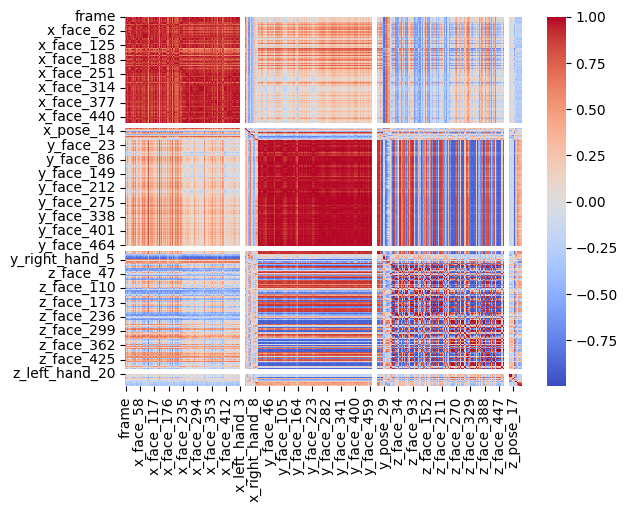

In [22]:
import seaborn as sns
import pandas as pd

def heat_map(df):

    correlation_matrix = df.corr()

    sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
    plt.show()

heat_map(sample_sequence_df)

<h5 style='text-align: right;' dir='rtl'>
ניתן לראות כי קיימת קורלציה די גבוהה בחלק מהפיצ'רים בציר האיקס בציר הוואי בחלק של הפנים, אך ברגעים שונים, ולכן קשה להצביע עד כה על קשר מובהק כלשהו.
 </h5>

<h5 style='text-align: right;' dir='rtl'>
ננסה כעת להשיג עוד מידע על הדאטא בעזרת ניתוח אשכולות. שיטה זו היא למעשה קיבוץ אובייקטים לקבוצות (אשכולות) כך שהאובייקטים הנמצאים באותה קבוצה דומים זה לזה יותר מאשר לאובייקטים השייכים לקבוצות אחרות. אם לדייק אז נשתמש באלגוריתם לפיו אנו מחלקים את המידע למספר מסוים של מרכזים, ובמקרה שלנו 3, וזאת לפי מרכזי כובד. כל תצפית משויכת לאחד מ"מרכזי הכובד". על ידי בחירה נכונה של מרכזי כובד ניתן לאתר את הקבוצות השונות.

נדרשות תצפיות רבות לשימוש באלגוריתם זה, כפי שיש בדאטא שלנו. בנוסף, מודל זה לא לינארי ולכן הוא אמור להתמודד עם סוגי התפלגויות שונים.
 </h5>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


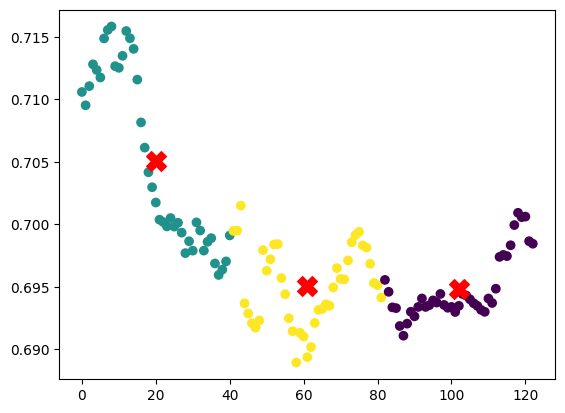

In [23]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def k_means(df):
    k = 3

    pipeline = make_pipeline(
        SimpleImputer(
            strategy='mean',
            missing_values=np.nan
            ),
        KMeans(n_clusters=k)
        )

    pipeline.fit(df)

    labels = pipeline.predict(df)

    centroids = pipeline.named_steps['kmeans'].cluster_centers_

    column_names = list(df.columns.values)
    plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=labels, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, color='red')
    plt.show()


k_means(sample_sequence_df)


<h5 style='text-align: right;' dir='rtl'>
גם כאן, המידע ששייך לכל מרכז כובד (בצבע שונה) די רחוק ממנו, ולכן לא ניתן להראות על קשר מסוים.
 </h5>

<h5 style='text-align: right;' dir='rtl'>
נמשיך כעת לשיטה של הורדת מימד בה מצמצמים מספר משתנים מתוך כלל המידע, על מנת לשמר כמה שיותר מהמשמעות של המידע עצמו.
 </h5>

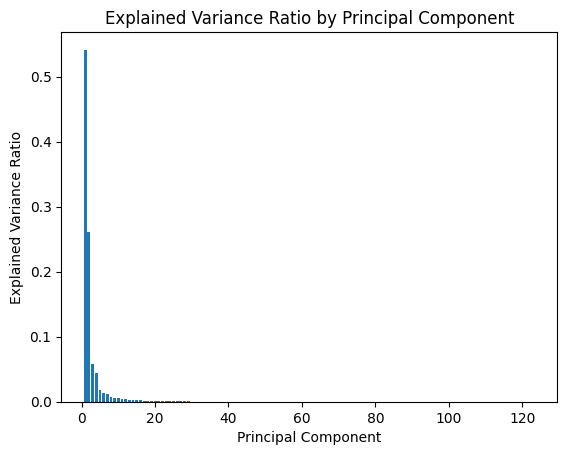

In [24]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
def dimensional_reduction(df: pd.DataFrame):
    df.dropna(how='all', axis=1, inplace=True)

    imputer = SimpleImputer(strategy='mean')
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    standardized_df = (df_imputed - df_imputed.mean()) / df_imputed.std()

    pca = PCA()
    principal_components = pca.fit_transform(standardized_df)

    pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

    explained_variance_ratio = pca.explained_variance_ratio_
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Principal Component')
    plt.show()



dimensional_reduction(sample_sequence_df)


<h5 style='text-align: right;' dir='rtl'>
כזכור, הויזואליזציה שלעיל מציגה רק סרטון אחד ולא את המידע כולו. ננסה לאחד את כל המידע לדאטאפריים אחד ונקרא שוב לכל מתודות הויזואליזציה
 </h5>

             frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1816796431       0  0.710588  0.699951  0.705657  0.691768  0.699669   
1816796431       1  0.709525  0.697582  0.703713  0.691016  0.697576   
1816796431       2  0.711059  0.700858  0.706272  0.693285  0.700825   
1816796431       3  0.712799  0.702518  0.707840  0.694899  0.702445   
1816796431       4  0.712349  0.705451  0.709918  0.696006  0.705180   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_11  \
sequence_id                                          ...                    
1816796431   0.701980  0.709724  0.610405  0.712660  ...        -0.245855   
1816796431   0.700467  0.709796  0.616540  0.713729  ...              NaN   
1816796431   0.703319  0.711549  0.615606  0.715143  ...              NaN   
1816796431   0.704794  0.712483  0.625044  0.715677  ...        -0.370770   
1816796431   0.706928  0.712685  

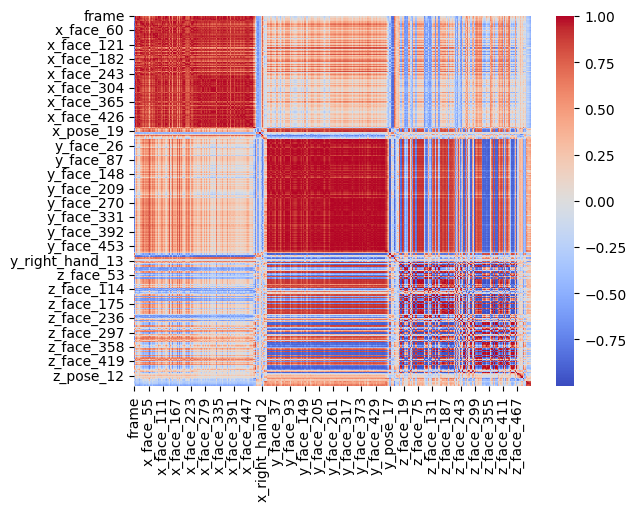

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


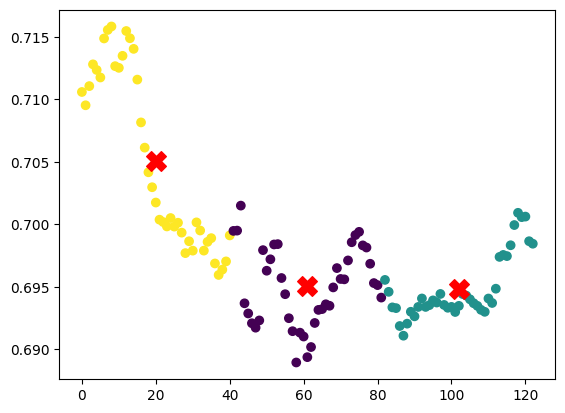

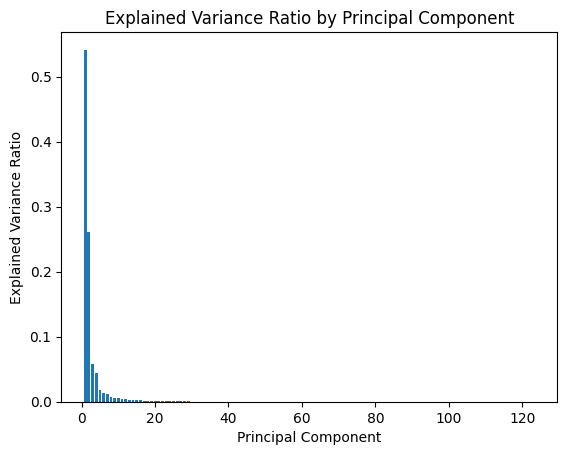

In [25]:
sequence_id_as_list = dataset_df['sequence_id'].to_list()
file_id_as_list = dataset_df['file_id'].to_list()
phrases_as_list = dataset_df['phrase'].to_list()

concatenated_df = sample_sequence_df
# for i, sequence_id in enumerate(sequence_id_as_list):
#     file_id = file_id_as_list[i]
#     phrase = phrases_as_list[i]

#     single_df = pq.read_table(
#         f"/content/drive/MyDrive/asl-fingerspelling/train_landmarks/{str(file_id)}.parquet",
#         filters=[[('sequence_id', '=', sequence_id)],]
#         ).to_pandas()

#     concatenated_df = pd.concat([concatenated_df, single_df], axis=0)

print(concatenated_df.head())
heat_map(concatenated_df)
k_means(concatenated_df)
dimensional_reduction(concatenated_df)


<h1 style='text-align: right;' dir='rtl'>
הצגת המידע עם mediapipe
</h1>

<h5 style='text-align: right;' dir='rtl'>
נציג את הביטוי
<b>3 creek house</b>
 בעזרת <a herf="https://developers.google.com/mediapipe/solutions/vision/hand_landmarker">hand landmarker apis</a> של <a herf="https://developers.google.com/mediapipe">ספריית mediapipe</a>.

הנקודות על היד מציגות את הנקודות שאחריהן אנו עוקבים במידע.

Reference: [Data visualization using mediapipe APIs by sknadig](https://www.kaggle.com/code/nadigshreekanth/data-visualization-using-mediapipe-apis)
</h5>

In [26]:
# Function create animation from images.

matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['savefig.pad_inches'] = 0
rc('animation', html='jshtml')

def create_animation(images):
    fig = plt.figure(figsize=(6, 9))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im=ax.imshow(images[0], cmap="gray")
    plt.close(fig)

    def animate_func(i):
        im.set_array(images[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(images), interval=1000/10)

<h5 style='text-align: right;' dir='rtl'>
בתמונה זאת ניתן לראות את 21 הנקודות שאחריהן אנו עוקבים בכל יד

![hand-landmarks (1).png](attachment:bd58b6bd-7c28-48d1-8dd4-6b11d0e3d4a8.png)

מקור: https://developers.google.com/mediapipe/solutions/vision/hand_landmarker
</h5>

In [27]:
# Extract the landmark data and convert it to an image using medipipe library.
# This function extracts the data for both hands.

mp_pose = mediapipe.solutions.pose
mp_hands = mediapipe.solutions.hands
mp_drawing = mediapipe.solutions.drawing_utils
mp_drawing_styles = mediapipe.solutions.drawing_styles

def get_hands(seq_df):
    images = []
    all_hand_landmarks = []
    for seq_idx in range(len(seq_df)):
        x_hand = seq_df.iloc[seq_idx].filter(regex="x_right_hand.*").values
        y_hand = seq_df.iloc[seq_idx].filter(regex="y_right_hand.*").values
        z_hand = seq_df.iloc[seq_idx].filter(regex="z_right_hand.*").values

        right_hand_image = np.zeros((600, 600, 3))

        right_hand_landmarks = landmark_pb2.NormalizedLandmarkList()

        for x, y, z in zip(x_hand, y_hand, z_hand):
            right_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
                right_hand_image,
                right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())

        x_hand = seq_df.iloc[seq_idx].filter(regex="x_left_hand.*").values
        y_hand = seq_df.iloc[seq_idx].filter(regex="y_left_hand.*").values
        z_hand = seq_df.iloc[seq_idx].filter(regex="z_left_hand.*").values

        left_hand_image = np.zeros((600, 600, 3))

        left_hand_landmarks = landmark_pb2.NormalizedLandmarkList()
        for x, y, z in zip(x_hand, y_hand, z_hand):
            left_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
                left_hand_image,
                left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())

        images.append([right_hand_image.astype(np.uint8), left_hand_image.astype(np.uint8)])
        all_hand_landmarks.append([right_hand_landmarks, left_hand_landmarks])
    return images, all_hand_landmarks

<h5 style='text-align: right;' dir='rtl'>
ניתן לראות כאן אנימציה של איך נראה סרטון מעובד של יד זזה
</h5>

In [28]:
# # Get the images created using mediapipe apis
# hand_images, hand_landmarks = get_hands(sample_sequence_df)
# # Fetch and show the data for right hand
# create_animation(np.array(hand_images)[:, 0])

<h1 style='text-align: right;' dir='rtl'>
 עיבוד ראשוני של המידע
 </h1>
<h5 style='text-align: right;' dir='rtl'>
 נארגן מחדש את המידע בפורמט של TFRECORDS
 במקום קובץ parquet
 פורמט זה עוצב ונועד לtensorflow ובשל כך יהיה מהיר יותר

Reference:

https://www.kaggle.com/code/irohith/aslfr-preprocess-dataset

https://www.kaggle.com/code/shlomoron/aslfr-parquets-to-tfrecords-cleaned
</h5>

<h5 style='text-align: right;' dir='rtl'>
קוד זה החליט להתעלם מזיהוי הפנים ולהתייחס אך ורק לידיים מתוך הנחה שמיכוון שלפנים אין תפקיד רשמי בשפת סימנים אמריקאית
לכלול את המידע על הפנים רק יבלבל את המערכת
</h5>

<h1 style='text-align: right;' dir='rtl'>
השגת הקודינאטות מהידיים
</h1>

<h5 style='text-align: right;' dir='rtl'>
בתמונה זאת ניתן לראות את הקודינאטות של היד בלבד
</h5>

![pose.png](attachment:1389643c-6068-4c7d-9275-0b42f25b836e.png)

[Image source](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker)

In [29]:
# Pose coordinates for hand movement.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

# יצירת תוויות מהקורדינאטות

In [30]:
X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

ייצור עמודות מהתוויות

In [31]:
FEATURE_COLUMNS = X + Y + Z

אחסון התוויות ברשימה

In [32]:
X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in LPOSE]

<h1 style='text-align: right;' dir='rtl'>
עיבוד ראשוני של המידע
</h1>

<h5 style='text-align: right;' dir='rtl'>
נייצר קבצים למידע ונשמור אותם כ tfrecords

צעד זה לוקח כ10 דקות בקוד המקורי אורך הפריים הוגדר כ128 אבל נאלצתי לחצות מספר זה ל64 מכיוון שכרטיס המסך שלי לא עמד בזכרון
</h5>

In [33]:
# Set length of frames to 128
FRAME_LEN = 64

# # Create directory to store the new data
# if not os.path.isdir("preprocessed"):
#     os.mkdir("preprocessed")
# else:
#     shutil.rmtree("preprocessed")
#     os.mkdir("preprocessed")

# # Loop through each file_id
# for file_id in tqdm(dataset_df.file_id.unique()):
#     # Parquet file name
#     pq_file = fr"/mnt/g/seminarion/data project/train_landmarks/{str(file_id)}.parquet"
#     # Filter train.csv and fetch entries only for the relevant file_id
#     file_df = dataset_df.loc[dataset_df["file_id"] == file_id]
#     # Fetch the parquet file
#     parquet_df = pq.read_table(fr"/mnt/g/seminarion/data project/train_landmarks/{str(file_id)}.parquet",
#                               columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()
#     # File name for the updated data
#     tf_file = fr"/mnt/g/seminarion/data project/preprocessed/{file_id}.tfrecord"
#     parquet_numpy = parquet_df.to_numpy()
#     # Initialize the pointer to write the output of
#     # each `for loop` below as a sequence into the file.
#     with tf.io.TFRecordWriter(tf_file) as file_writer:
#         # Loop through each sequence in file.
#         for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
#             # Fetch sequence data
#             frames = parquet_numpy[parquet_df.index == seq_id]

#             # Calculate the number of NaN values in each hand landmark
#             r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
#             l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
#             no_nan = max(r_nonan, l_nonan)

#             if 2*len(phrase)<no_nan:
#                 features = {FEATURE_COLUMNS[i]: tf.train.Feature(
#                     float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
#                 features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
#                 record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
#                 file_writer.write(record_bytes)

<h5 style='text-align: right;' dir='rtl'>
טעינת המידע המעובד
</h5>

<h1 style='text-align: right;' dir='rtl'>
שמירת ה tfrecords ברשימה
</h1>

In [34]:
tf_records = dataset_df.file_id.map(lambda x: f'/content/drive/MyDrive/asl-fingerspelling/preprocessed/{x}.tfrecord').unique()
print(f"List of {len(tf_records)} TFRecord files.")

List of 68 TFRecord files.


<h1 style='text-align: right;' dir='rtl'>
 טעינת ה TF records לקובץ json
 </h1>

<h5 style='text-align: right;' dir='rtl'>
קובץ הjson מכיל את ערכי התווים פה אנו מוסיפים תו להתחלת וסוף המילה ועוד תו P לריפוד אחרי המילה
</h5>

In [35]:
with open ("/content/drive/MyDrive/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)

# Add pad_token, start pointer and end pointer to the dict
pad_token = 'P'
start_token = '<'
end_token = '>'
pad_token_idx = 59
start_token_idx = 60
end_token_idx = 61

char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx
num_to_char = {j:i for i,j in char_to_num.items()}

In [36]:
# Reference: https://www.kaggle.com/code/irohith/aslfr-transformer/notebook

# Function to resize and add padding.
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

# Detect the dominant hand from the number of NaN values.
# Dominant hand will have less NaN values since it is in frame moving.
def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)

    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)

    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)

    # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose

        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)

        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose

    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)

    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)

    x = tf.concat([hand, pose], axis=1)
    x = resize_pad(x)

    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

<h1 style='text-align: right;' dir='rtl'>
 יצירת פונקציה לעיבוד ה TFrecords
</h1>

<h5 style='text-align: right;' dir='rtl'>
הפונקציה ממירה את המידע שנטען לTFrecords

והופכת אותו לטנסור שאפשר לנתח עם tensorflow

In [37]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)

    return landmarks, phrase

<h1 style='text-align: right;' dir='rtl'>
פונקציה להמרת המידע
</h1>
<h5 style='text-align: right;' dir='rtl'>
המרות שונות למידע והוספת הביטוי לווקטור שנוסף
</h5>

In [38]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def convert_fn(landmarks, phrase):
    # Add start and end pointers to phrase.
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    # Vectorize and add padding.
    phrase = tf.pad(phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode = 'CONSTANT',
                    constant_values = pad_token_idx)
    # Apply pre_process function to the landmarks.
    return pre_process(landmarks), phrase


<h5 style='text-align: right;' dir='rtl'>
נשתמש בפונקציות כדי לייצר את הדאטהסט
</h5>

<h1 style='text-align: right;' dir='rtl'>
פיצול הדאטהסט לאימונים ובדיקה
</h1>

In [39]:
batch_size = 64
train_len = int(0.8 * len(tf_records))

train_ds = tf.data.TFRecordDataset(tf_records[:train_len]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
valid_ds = tf.data.TFRecordDataset(tf_records[train_len:]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

<h1 style='text-align: right;' dir='rtl'>
 יצירת המודל  של הטרנספורמר
 </h1>
<h5 style='text-align: right;' dir='rtl'>
נשתמש ב<a herf="https://he.wikipedia.org/wiki/%D7%98%D7%A8%D7%A0%D7%A1%D7%A4%D7%95%D7%A8%D7%9E%D7%A8_(%D7%9C%D7%9E%D7%99%D7%93%D7%AA_%D7%9E%D7%9B%D7%95%D7%A0%D7%94)">טרנספורמר</a>
כדי לאמן את המודל. <b>טרנספורמרים</b> נועדו למידע רציף.
במהלך ההכנה לפרויקט למדנו על דרך הפעולה של טרנספורמר והבנו למה הוא מושלם למטרותינו
טרנספומר עובד על הרעיון של "תשומת לב" הטרנספורמר מנתח את הקלט ומפצל אותו ל "טוקנים" חלקים "אטומים" בקלט מנתח את הקשרים בינהם לפי כמה פעמים טוקנים מופיעים ביחד בקלט וממיר את כל הקשרים הללו
למספר לאחר מכן הטרנספורמר מקבל כל טוקן בקלט מבין לאיזה טוקן יש לה קשר מבין כל המילים ומוציא ערך של הטוקן שאליה יש לו הכי הרבה קשר. יתכן שהמילה תהיה עצמה
חלק זה בטרנספורמר נקרא המקודד ועליו נסביר בהמשך. חלק זה מתחבר לרכיב השני מפר הקידוד חלק זה מבין את הקשר בין הערך שניתן על ידי המקודד ערך שמייצג את המילה בהקשרה.
ומבין את הקשר שלה לטוקנים במילה שאליה מתרגמים במקרה זה אנגלית.

 ביצירת המודל נעתיק עקרונות ממודלים לזיהוי דיבור <a herf="https://keras.io/examples/audio/transformer_asr/">Automatic Speech Recognition with Transformer</a> כדוגמת זה.
 ישנם דמיונות רבים בין דיבור לסימון בשפת הסימנים שניהם קלט שמובא בצורה לא מאורגנת כלומר יתכן ששני קלטים יהיו מזוהים בתור אותו טוקן אך יראו שונה לגמרי מבחינת קלט
 כמו שבזיהוי קולי יתכן ואדם אמר את אותה מילה או אפילו את אותה הברה וזה ישמע שונה לגמרי בגלל גורמים חיצוניים כמו איכות המיקרופון,עוצמת הקול, מבטא, או פשוט העובדה שלאנשים שונים יש קולות שונים
 בבעיה זו נתקל בבעיות דומות בזיהוי הקלט לאנשים יש גדלי ידיים שונים תוכנת הזיהוי של גוגל לא קלטה את מיקום הידיים באופן מושלם ועוד
 התרגום בסופו של דבר נעשה גם הוא לאנגלית משמע שיתכן ונמצא גרסאות טובות של חלק מפר הקידוד במודל
 ליצירת הטוקנים אנו כעת בוחנים את האופצייה להשתמש באלגוריתם CTC
 לשם יצירת הטוקנים אך עוד לא הצלחנו לממש אותו
 </h5>
![picnogrid.gif](attachment:9c4fc53c-6b08-4404-9369-34f391fb78d6.gif)

<h1 style='text-align: right;' dir='rtl'>יצירת שכבת הקלט
</h1>
<h5 style='text-align: right;' dir='rtl'>

נשתמש במעיין מודל CNN פשוט
פשוט לעיבוד הנתונים הראשוניים והבנת קשרים. בהמשך בחלק זה ננסה להשתמש ב CTC Segmentation אבל כרגע כמו ש CNN הצליח להבין את ה MNIST

ללא יצירת אלגוריתם מותאם מראש יתכן וגם פה ה CNN יצליח ליצור בעצמו טוקנים

בדוגמא שהבאתי בהצגת תחום הידע פשוט "זרקתי"  את הנתונים מה MNIST על הרשת ואמרתי לה שאני מצפה לקבל 10 טוקנים ואימנתי אותה על זה ואכן הצלחתי לקבל את ה10 הנכונים למרות שהמספרים היו שונים בהרבה אספקטים
יתכן בגלל הלוגיקה הזאת רשת ניורונים תצליח להבין לבד קשרים בין המילים אבל כרגע אנחנו יודעים שזה לא אפוטימלי זה למה ננסה ליישם CTC במקום  
</h5>

In [40]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class LandmarkEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

<h1 style='text-align: right;' dir='rtl'>
שכבת הקידוד
</h1>
<h5 style='text-align: right;' dir='rtl'>
כרגיל ל KERAS

דברים כמו "תשומת לב" הם שכבה אחת שניתן לעשות בשורת קוד אחת
</h5>


In [41]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

<h1 style='text-align: right;' dir='rtl'>
 שכבת הפרת ההצפנה
 </h1>

In [42]:
# Customized to add `training` variable
# Reference: https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target, training):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att, training = training))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out, training = training) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training = training))
        return ffn_out_norm

<h1 style='text-align: right;' dir='rtl'>
סוף מודל הטרנספורמר
</h1>
<h5 style='text-align: right;' dir='rtl'>
המודל לוקח קורדינאטות וחוזה רצף של של תווים. זה מסופק למפר הקידוד שמנסה לחזות את התו הבא


הביצועים נמדדים לפי מרחק לווינשטיין מרחק המודד את כמות העריכות הנדרשת כדי להגיע מהקלט שקיבלנו לקלט הרצוי
פה אנו מגדירים לו מה לעשות בכל צעד אימונים ומחברים את המקודד למפר הקידוד
בנוסף אנחנו קובעים שפונקציית ההפסד תהיה מרחק לווינשטיין מהפלט הרצוי
</h5>

In [43]:
# Customized to add edit_dist metric and training variable.
# Reference:
# https://www.kaggle.com/code/irohith/aslfr-transformer/notebook
# https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=60,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.acc_metric = keras.metrics.Mean(name="edit_dist")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = LandmarkEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y, training)
        return y

    def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training)
        y = self.decode(x, target, training)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]

        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Computes the Levenshtein distance between sequences since the evaluation
        # metric for this contest is the normalized total levenshtein distance.
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target),
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def test_step(self, batch):
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]

        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        # Computes the Levenshtein distance between sequences since the evaluation
        # metric for this contest is the normalized total levenshtein distance.
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target),
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training = False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training = False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

<h5 style='text-align: right;' dir='rtl'>
הפונקציה הזאת מראה לנו את התחזית לעומת הפלט הנכון
</h5>

In [44]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=60, target_end_token_idx=61
    ):
        """Displays a batch of outputs after every 4 epoch

        Args:
            batch: A test batch
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 4 != 0:
            return
        source = self.batch[0]
        target = self.batch[1].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")

<h1 style='text-align: right;' dir='rtl'>
אימון הטרנספורמר
</h1>
<h5 style='text-align: right;' dir='rtl'>
לאחר הגדרת הטרנספורמר אנו יוצרים אינסטנס שלו ומאמנים אני החלטתי לעשות 20 עידנים
</h5>

In [45]:
# # Transformer variables are customized from original keras tutorial to suit this dataset.
# # Reference: https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

# batch = next(iter(valid_ds))

# # The vocabulary to convert predicted indices into characters
# idx_to_char = list(char_to_num.keys())
# display_cb = DisplayOutputs(
#     batch, idx_to_char, target_start_token_idx=char_to_num['<'], target_end_token_idx=char_to_num['>']
# )  # set the arguments as per vocabulary index for '<' and '>'

# model = Transformer(
#     num_hid=200,
#     num_head=4,
#     num_feed_forward=400,
#     source_maxlen = FRAME_LEN,
#     target_maxlen=64,
#     num_layers_enc=2,
#     num_layers_dec=1,
#     num_classes=62
# )
# loss_fn = tf.keras.losses.CategoricalCrossentropy(
#     from_logits=True, label_smoothing=0.1,
# )


# optimizer = keras.optimizers.Adam(0.0001)
# model.compile(optimizer=optimizer, loss=loss_fn)

# history = model.fit(train_ds, validation_data=valid_ds, callbacks=[display_cb], epochs=20)

<h1 style='text-align: right;' dir='rtl'>
סרטוט פונקציית ההפסד
</h1>

In [46]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.legend(['training loss', 'val_loss'])

<h1 style='text-align: right;' dir='rtl'>
ייצוא המודל
</h1>

In [47]:
# class TFLiteModel(tf.Module):
#     def __init__(self, model):
#         super(TFLiteModel, self).__init__()
#         self.target_start_token_idx = start_token_idx
#         self.target_end_token_idx = end_token_idx
#         # Load the feature generation and main models
#         self.model = model

#     @tf.function(input_signature=[tf.TensorSpec(shape=[None, len(FEATURE_COLUMNS)], dtype=tf.float32, name='inputs')])
#     def __call__(self, inputs, training=False):
#         # Preprocess Data
#         x = tf.cast(inputs, tf.float32)
#         x = x[None]
#         x = tf.cond(tf.shape(x)[1] == 0, lambda: tf.zeros((1, 1, len(FEATURE_COLUMNS))), lambda: tf.identity(x))
#         x = x[0]
#         x = pre_process(x)
#         x = x[None]
#         x = self.model.generate(x, self.target_start_token_idx)
#         x = x[0]
#         idx = tf.argmax(tf.cast(tf.equal(x, self.target_end_token_idx), tf.int32))
#         idx = tf.where(tf.math.less(idx, 1), tf.constant(2, dtype=tf.int64), idx)
#         x = x[1:idx]
#         x = tf.one_hot(x, 59)
#         return {'outputs': x}

# tflitemodel_base = TFLiteModel(model)

In [48]:
# model.save_weights("model.h5")

In [49]:
# keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflitemodel_base)
# keras_model_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]#, tf.lite.OpsSet.SELECT_TF_OPS]
# tflite_model = keras_model_converter.convert()
# with open(r"/mnt/g/seminarion/data project/working/model.tflite", 'wb') as f:
#     f.write(tflite_model)

# infargs = {"selected_columns" : FEATURE_COLUMNS}

# with open(r"/mnt/g/seminarion/data project/working/inference_args.json", "w") as json_file:
#     json.dump(infargs, json_file)

In [50]:
# interpreter = tf.lite.Interpreter("/mnt/g/seminarion/data project/working/model.tflite")

# REQUIRED_SIGNATURE = "serving_default"
# REQUIRED_OUTPUT = "outputs"

# with open (r"/mnt/g/seminarion/data project/character_to_prediction_index.json", "r") as f:
#     character_map = json.load(f)
# rev_character_map = {j:i for i,j in character_map.items()}

# found_signatures = list(interpreter.get_signature_list().keys())

# if REQUIRED_SIGNATURE not in found_signatures:
#     raise KernelEvalException('Required input signature not found.')

# prediction_fn = interpreter.get_signature_runner("serving_default")
# output = prediction_fn(inputs=batch[0][0])
# prediction_str = "".join([rev_character_map.get(s, "") for s in np.argmax(output[REQUIRED_OUTPUT], axis=1)])
# print(prediction_str)